# Data Gathering

In [1]:
%matplotlib inline

In [2]:
from utils.io import dataframe_viewer, data_merger, data_validation, data_filter, fix_duplicates, \
compute_borehole_length, files_search, data_overview
import re, os
import numpy as np
import geopandas as gpd
import pandas as pd
import datetime as dtm
import matplotlib.pyplot as plt
from definitions import ROOT_DIR

In [3]:
def create_df(files, verbose=True): # find another name for this function
    """
    create dataframes from files and test if they contain position informations
    files: list of files name
    """
    cnt = 0
    dfs = []
    for f in files:
        cnt += 1
        df = pd.read_csv(f, delimiter=',')
        dfs.append(df)
        
        if verbose:
            if 'X' in list(df.columns): msg = ' --> Coordinates'
            else: msg = ' --> No coordinates'

            print(f"df{cnt} : {msg}")
            
    return dfs

## Reading files

In [4]:
work_dir = ROOT_DIR+'/CF_data/Result_traitem/'
save_dir = ROOT_DIR+'/CF_data/Donnees_fusionnees/'

In [5]:
# create my dictionary structure to retrieve good files (Keynames !!!)
files_dict={'Borehole':0,'Piezometer':0,'Piezair':0,'Trench':0,'Litho':0,'Equipm':0,
        'Measure':0,'Sample':0,'Analysis':0,'Facility':0}

In [6]:
files_search(work_dir, files_dict, prefix='', skip='source')

Borehole  	:  7
Piezometer  	:  17
Piezair  	:  2
Trench  	:  1
Litho  	:  7
Equipm  	:  3
Measure  	:  6
Sample  	:  27
Analysis  	:  21
Facility  	:  4


In [7]:
how=['inner', 'outer', 'left', 'right']

In [8]:
f = False
t = True

# ----------------------------------------------------------------------

In [9]:
files_dict['Litho']

['/home/yanathan/Projects/GSDMA/CF_data/Result_traitem/database_Memoris3/Drains_Pz_ENEL_Lithology.csv',
 '/home/yanathan/Projects/GSDMA/CF_data/Result_traitem/database_Memoris3/Profils_sol_Lithology.csv',
 '/home/yanathan/Projects/GSDMA/CF_data/Result_traitem/database_Memoris3/Result_sol_Lithology.csv',
 '/home/yanathan/Projects/GSDMA/CF_data/Result_traitem/donnees_terrain_2019/Log_Lithology.csv',
 '/home/yanathan/Projects/GSDMA/CF_data/Result_traitem/profils_sols_donnees_forages/Log_Lithology.csv',
 '/home/yanathan/Projects/GSDMA/CF_data/Result_traitem/vUmons_logsFor/Sond2017v2_Lithology.csv',
 '/home/yanathan/Projects/GSDMA/CF_data/Result_traitem/vUmons_logsFor/Synthese_Lithology.csv']

In [10]:
files_dict['Borehole']

['/home/yanathan/Projects/GSDMA/CF_data/Result_traitem/Forage_Pilote/leve_Z_elect_pos_Boreholes.csv',
 '/home/yanathan/Projects/GSDMA/CF_data/Result_traitem/Prof_contact_sol_forage/Feuil1_Boreholes.csv',
 '/home/yanathan/Projects/GSDMA/CF_data/Result_traitem/database_Memoris3/Profils_sol_Boreholes.csv',
 '/home/yanathan/Projects/GSDMA/CF_data/Result_traitem/donnees_terrain_2019/Donnees_forage_Boreholes.csv',
 '/home/yanathan/Projects/GSDMA/CF_data/Result_traitem/profils_sols_donnees_forages/Equipement_Boreholes.csv',
 '/home/yanathan/Projects/GSDMA/CF_data/Result_traitem/profils_sols_donnees_forages/Log_Boreholes.csv',
 '/home/yanathan/Projects/GSDMA/CF_data/Result_traitem/profils_sols_donnees_forages/donnees_forage_Boreholes.csv']

In [11]:
file1= work_dir + 'donnees_terrain_2019/Log_Lithology.csv' # 3
file2= work_dir + 'donnees_terrain_2019/Donnees_forage_Boreholes.csv' # 6

df1, df2 = create_df([file1, file2])
dataframe_viewer(df1, rows=3, un_val='ID', view=t), dataframe_viewer(df2, rows=3, un_val='ID', view=t)

df1 :  --> No coordinates
df2 :  --> Coordinates
Rows : 86, columns : 7, Unique values on col 'ID': 24


interactive(children=(IntSlider(value=3, description='rows', max=86, min=3, readout=False), IntSlider(value=7,…

Rows : 16, columns : 18, Unique values on col 'ID': 16


interactive(children=(IntSlider(value=3, description='rows', max=16, min=3, readout=False), IntSlider(value=12…

(None, None)

In [12]:
df1['ID'] = df1['ID'].apply(lambda x: str(x).strip('F'))

In [13]:
df1 = df1[['ID','Description','Litho_top','Litho_base']].copy()
df2 = df2[['ID','X','Y','Z','Long_for','Diam_for']].copy()

In [14]:
mdf, conflict_df = data_merger(df1, df2, how=how[1], on='ID', dist_max=1., drop_skip_col=['index'])

In [15]:
compute_borehole_length(mdf, mode='thickness', top_col='Litho_top', base_col='Litho_base', )

In [16]:
dataframe_viewer(mdf, rows=10, un_val='ID', view=t)

Rows : 86, columns : 10, Unique values on col 'ID': 24


interactive(children=(IntSlider(value=10, description='rows', max=86, min=10, readout=False), IntSlider(value=…

In [ ]:
df3 = pd.read_csv(save_dir+'forages_coords.csv', sep=';')
df3.replace(',', '.', regex=True, inplace=True)
df3.drop(columns='Campagne', inplace=True)

In [20]:
df3.ID = df3.ID.astype(str)
df3.X = df3.X.astype(float)
df3.Y = df3.Y.astype(float)
df3.Z = df3.Z.astype(float)

In [21]:
df3.dtypes

ID     object
X     float64
Y     float64
Z     float64
dtype: object

In [22]:
mdf, conflict_df = data_merger(mdf, df3, how=how[1], on='ID', dist_max=1., drop_skip_col=['index'])

In [23]:
dataframe_viewer(mdf, rows=10, un_val='ID', view=t)

Rows : 89, columns : 10, Unique values on col 'ID': 27


interactive(children=(IntSlider(value=10, description='rows', max=89, min=10, readout=False), IntSlider(value=…

## Save

In [24]:
mdf.to_csv(save_dir+'Pilote_test.csv', index=False)

## Plot

In [25]:
mdf = gpd.GeoDataFrame(mdf, geometry=gpd.points_from_xy(mdf.X, mdf.Y, crs=str('EPSG:31370')))

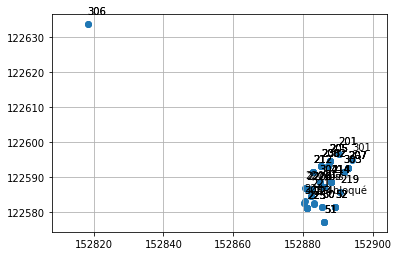

In [26]:
ax = mdf.plot()
plt.axis('equal')
plt.grid('on')
for x, y, label in zip(mdf.geometry.x, mdf.geometry.y, mdf.ID):
    ax.annotate(label, xy=(x, y), xytext=(0, 10), textcoords="offset points")

In [27]:
len(mdf)

89